# **FAVOUR TAIWO ECX Assignment 2**

## PYTOUCH

In [44]:
# Define paths for data
data_dir = '../data/Building Types' # Ensure the name of the folder is set to this.
class_names = ['Bungalow', 'Highrise', 'Storey-Building']

In [45]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [46]:

# Hyperparameters
IMAGE_HEIGHT = 128  # Adjust based on your dataset
IMAGE_WIDTH = 128   # Adjust based on your dataset
BATCH_SIZE = 8      # Reduced batch size to avoid OOM
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
ACCUMULATION_STEPS = 4  # Gradient accumulation steps


In [47]:

# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),  # Resize images
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load dataset

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train (70%), validation (20%), and test (10%)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [48]:

# Define the model
# Import the model class
from model import BuildingClassifier


# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BuildingClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [49]:

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad()  # Reset gradients at the start of each epoch

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels) / ACCUMULATION_STEPS  # Scale loss
        loss.backward()  # Accumulate gradients

        # Update weights every `accumulation_steps` batches
        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Reset gradients

        # Compute statistics
        running_loss += loss.item() * ACCUMULATION_STEPS
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    # Print training statistics
    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100.0 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")



Epoch [1/10], Train Loss: 0.8959, Train Acc: 58.06%
Validation Loss: 0.7397, Validation Acc: 67.36%
Epoch [2/10], Train Loss: 0.6872, Train Acc: 68.46%
Validation Loss: 0.7134, Validation Acc: 69.04%
Epoch [3/10], Train Loss: 0.5825, Train Acc: 74.19%
Validation Loss: 0.6214, Validation Acc: 71.97%
Epoch [4/10], Train Loss: 0.4826, Train Acc: 80.76%
Validation Loss: 0.5736, Validation Acc: 76.57%
Epoch [5/10], Train Loss: 0.4356, Train Acc: 83.99%
Validation Loss: 0.5671, Validation Acc: 77.41%
Epoch [6/10], Train Loss: 0.3219, Train Acc: 89.25%
Validation Loss: 0.6437, Validation Acc: 71.13%
Epoch [7/10], Train Loss: 0.3021, Train Acc: 90.44%
Validation Loss: 0.6748, Validation Acc: 67.78%
Epoch [8/10], Train Loss: 0.2473, Train Acc: 90.92%
Validation Loss: 0.6004, Validation Acc: 77.41%
Epoch [9/10], Train Loss: 0.1821, Train Acc: 94.98%
Validation Loss: 0.5898, Validation Acc: 75.73%
Epoch [10/10], Train Loss: 0.1908, Train Acc: 94.15%
Validation Loss: 0.6331, Validation Acc: 74.48%

In [50]:

# Evaluate on the test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [51]:

# Classification report
class_names = list(dataset.class_to_idx.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                 precision    recall  f1-score   support

       Bungalow       0.76      0.58      0.66        43
      High-rise       0.72      0.87      0.79        15
Storey-building       0.71      0.79      0.75        63

       accuracy                           0.73       121
      macro avg       0.73      0.75      0.73       121
   weighted avg       0.73      0.73      0.72       121



In [52]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[25  0 18]
 [ 0 13  2]
 [ 8  5 50]]


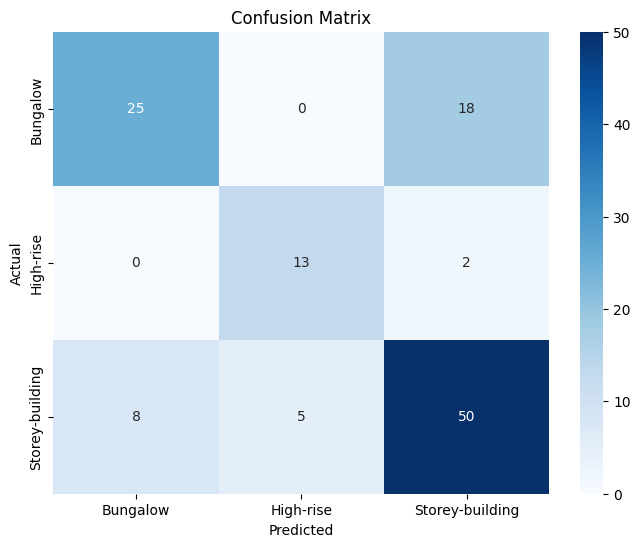

In [53]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Save Model

In [64]:
from pathlib import Path

# Save the model
torch.save(model.state_dict(), "../model/ExportedModel.pth")